## Purpose

We need to find positions and tangents on a curved curve or surface 
from a field of sample points (either in time and space).  

The conventional approach is to smooth the dataset and take the 
differential from the smoothed curves.  However, this attenuates the data.  

What we try here is to fit polynomial curves/surfaces to a limited region 
(weighted by the centre of the region) and then differentiate these.  


This notebook is for testing out the function calls and comparing 
the accuracy of the measurements depending on noise added and sample rate.


### Polyfit interaction

Given an input function, we can sample and evaluate it with linspace, and then 
interactively compare what will happen with different polyfit degrees, 
weights (controlled by attenuation) and random values.

The 5th order input function gets perfectly matched by a 5th order polynomial, 
because any point on it is valid for the curve fit.  

Second input function is the concatenation of two exponential decay curves
to simulate temperature sensing.  Here the higher degrees don't give such 
an advantage.  


In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy
from ipywidgets import widgets
from IPython.display import HTML
import matplotlib


# we use numpy.polyval((a,b,c), x) = a*x**2 + b*x + c
def diffpoly(p):
    return [ e*c  for e, c in zip(range(len(p)-1, 0, -1), p) ]

# 5th order polynomial input
def inputfunc(x):
    polyinputcurve = (-0.06, 0.4, 4, -2, 0, 3)
    return numpy.polyval(polyinputcurve, x)

def dinputfunc(x):
    polyinputcurve = (-0.06, 0.4, 4, -2, 0, 3)
    return numpy.polyval(diffpoly(polyinputcurve), x)

# two exponential decay curves
def inputfunc(x):
    return numpy.exp(numpy.minimum(-x, 0)) - 0.005*numpy.exp(-numpy.minimum(x, 0))
def dinputfunc(x):
    return -numpy.exp(numpy.minimum(-x, 0))*(x>0) + 0.005*numpy.exp(-numpy.minimum(x, 0))*(x<0)


#matplotlib.style.use('fivethirtyeight')
dwstyle = {'description_width': 'initial'}
display(HTML("<style>.widget-slider .widget-readout { background: cyan; min-width: 30px }</style>"))  # https://github.com/jupyter-widgets/ipywidgets/issues/1937

wdegree = widgets.IntSlider(description="deg", value=2, min=1, max=5, continuous_update=False, style=dwstyle)
wspacing = widgets.IntSlider(description="linspace", value=50, min=20, max=500, continuous_update=False, style=dwstyle)
watten = widgets.FloatSlider(description="atten", value=2.0, min=0.0, max=90.0, continuous_update=False, style=dwstyle)
wrwidth = widgets.FloatSlider(description="rwidth", value=4.0, min=0.1, max=5.0, continuous_update=False, style=dwstyle)
wnoisepos = widgets.FloatSlider(description="noiseP", value=0.0, min=0.0, max=0.1, step=0.001, continuous_update=False, style=dwstyle)
wnoise = widgets.FloatSlider(description="noise", value=0.0, min=0.0, max=100.0, continuous_update=False, style=dwstyle)
wxrange = widgets.FloatRangeSlider(description="xrange", value=(-5.0, 5.0), min=-5.0, max=5.0, continuous_update=False, style=dwstyle)
wmode = widgets.Dropdown(options=["abs", "diff"], value='abs', continuous_update=False)

wxrange.layout.width = "500px"
wmode.layout.width = "100px"

hbox1 = widgets.HBox([wdegree, wspacing])
hbox2 = widgets.HBox([watten, wrwidth])
hbox3 = widgets.HBox([wnoise, wnoisepos])
hbox4 = widgets.HBox([wxrange, wmode])
ui = widgets.VBox([hbox1, hbox2, hbox3, hbox4])

def fitslopespacings(lspacing, mx, mr, weightatten, deg, noisepos, noisescale):
    xs = numpy.linspace(-10, 10, lspacing)
    xs = xs + numpy.random.normal(0, noisepos, len(xs))
    xswindow = numpy.array([ x  for x in xs  if abs(x-mx)<mr ])
    yswindow = inputfunc(xswindow)
    yswindow = yswindow + numpy.random.normal(0, noisescale, len(yswindow))
    weights = 1/(1/weightatten + (xswindow - mx)**2)  if weightatten != 0  else numpy.ones(len(xswindow))

    polym = numpy.polyfit(xswindow, yswindow, deg=deg, w=weights)

    return numpy.polyval(polym, mx), numpy.polyval(diffpoly(polym), mx)

def plotfigure(wdegree, wspacing, wrwidth, watten, wnoisepos, wnoise, xrange, wmode):
    lmxs = numpy.linspace(xrange[0], xrange[1], 50)
    lposs, lslopes = [ ], [ ]
    for mx in lmxs:
        lpos, lslope = fitslopespacings(wspacing, mx, wrwidth, watten, wdegree, wnoisepos, wnoise)
        lposs.append(lpos)
        lslopes.append(lslope)

    lposstrue = inputfunc(lmxs)
    lslopestrue = dinputfunc(lmxs)
    
    plt.figure(figsize=(11,5))
    plt.subplot(121)
    plt.title("y-value")
    
    if wmode == "abs":
        plt.plot(lmxs, lposs)
        plt.plot(lmxs, lposstrue)
    else:
        plt.plot(lmxs, lposs-lposstrue)
        
    plt.subplot(122)
    plt.title("dy-value")
    if wmode == "abs":
        plt.plot(lmxs, lslopes)
        plt.plot(lmxs, lslopestrue)
    else:
        plt.plot(lmxs, lslopes - lslopestrue)
    plt.show() 
    
params = {'wdegree': wdegree, "wspacing":wspacing, "watten":watten, "wnoise":wnoise, "wnoisepos":wnoisepos, 
          'xrange':wxrange, "wrwidth":wrwidth, "wmode":wmode }
outputfigure = widgets.interactive_output(plotfigure, params)
#outputfigure.layout.height = '400px'
display(ui, outputfigure);



Output()

### Reproduction of polyfit calculation
Reproduce the basic calculations made by polyfit in order to 
extend it to two dimensions (surface shapes).


In [67]:
import numpy

# See: 
# https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python
    
xs = numpy.linspace(-3, 1, 60)
polyinputcurve = (-0.06, 0.4, 4, -2, 0, 3)
ys = numpy.polyval(polyinputcurve, xs)

p = numpy.polyfit(xs, ys, deg=2)

A = numpy.array([xs**2, xs, xs*0+1]).T
B = ys
coeff, r, rank, s = numpy.linalg.lstsq(A, B, rcond=-1)

print("without weights")
print(p)
print(coeff)

print("with weights")
weights = 1/(2+(xs+1)**2)
A = A*numpy.array([weights]*A.shape[1]).T
B = B*weights

p = numpy.polyfit(xs, ys, deg=2, w=weights)
coeff, r, rank, s = numpy.linalg.lstsq(A, B, rcond=-1)

print(p)
print(coeff)


without weights
[-8.52094226  1.08359528  6.04063071]
[-8.52094226  1.08359528  6.04063071]
with weights
[-8.93318168 -0.73175645  5.12425453]
[-8.93318168 -0.73175645  5.12425453]


### Application of general polyfit equation to 2D case

We extend the numpy.polyfit code (as replaced) to 2D using the 
same interface


In [107]:
A = numpy.array([X**2, X, X*0+1]).T
weights = 1/(2+(X+1)**2)

numpy.array([weights]*A.shape[1]).T



array([[0.33333333, 0.33333333, 0.33333333],
       [0.32174688, 0.32174688, 0.32174688],
       [0.31040413, 0.31040413, 0.31040413],
       ...,
       [0.17888999, 0.17888999, 0.17888999],
       [0.17264467, 0.17264467, 0.17264467],
       [0.16666667, 0.16666667, 0.16666667]])

In [124]:
numpy.matmul(numpy.array([weights]).T, numpy.ones((1,3)))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.32174688, 0.32174688, 0.32174688],
       [0.31040413, 0.31040413, 0.31040413],
       ...,
       [0.17888999, 0.17888999, 0.17888999],
       [0.17264467, 0.17264467, 0.17264467],
       [0.16666667, 0.16666667, 0.16666667]])

In [116]:
numpy.matmul(weights, numpy.ones((3,1)))

ValueError: shapes (400,) and (3,1) not aligned: 400 (dim 0) != 3 (dim 0)

In [152]:
def polyfitsurf(x, y, z, deg, w=None):
    pl = [x*0+1]   # constant array
    for d in range(1, deg+1):
        pl = [x**(d-j)*y**(j)  for j in range(0, d+1) ] + pl
    A = numpy.array(pl).T
    B = z
    if w is not None:
        #A = A*numpy.ones([w]*A.shape[1]).T
        A = A*numpy.matmul(numpy.array([weights]).T, numpy.ones((1,A.shape[1])))
        B = B*w
    coeff, r, rank, s = numpy.linalg.lstsq(A, B, rcond=-1)
    return coeff

def polysurfnormal0(coeff):
    # normalize (1, 0, coeff[-3]) x (0, 1, coeff[-2])
    p = numpy.array((-coeff[-3], -coeff[-2], 1))
    psq = sum(p*p)
    return p*(1/numpy.sqrt(psq) if psq else 1)



In [153]:
# testing the above functions
x = numpy.linspace(0, 1, 13)
y = numpy.linspace(0, 1, 14)
X, Y = numpy.meshgrid(x, y, copy=False)
X = X.flatten()
Y = Y.flatten()
Z = X*4 + Y*X*9 + numpy.random.rand(*X.shape)*0.001

weights = 1/(2+(X+1)**2)
print(list(polyfitsurf(X, Y, Z, 2, w=weights)))
print(list(polyfitsurf(X, Y, Z, 3, w=weights)))

Z = X*3 + X**2 + X*Y - Y*9
weights = 1/(0.03+(X**2 + Y**2))

c = polyfitsurf(X, Y, Z, 2, weights)
print(list(c))
print(list(polysurfnormal0(c)))


[0.00015486260019500125, 8.999906615150085, 0.0003589748995475919, 3.9998194822337103, -0.00028098468752020707, 0.0005467744887740179]
[0.0006450254636690627, 0.0002453974026897206, -0.0012658201421815302, 0.0007679175692123942, -0.0008713212442476589, 9.000953158493619, -0.000325450033629484, 4.0000454684527, -0.0002783403552296166, 0.0005592043605729844]
[1.0000000000000038, 0.9999999999999838, 7.745486603719143e-15, 3.000000000000003, -9.000000000000002, -3.6969116155233916e-16]
[-0.31448545101657577, 0.9434563530497265, 0.10482848367219182]


### Apply polyfitsurf to point scans

Do this in various 2D patches of radius 0.1m and work out their z position and 
normal direction by fitting 2nd order polynomial surfaces to them.


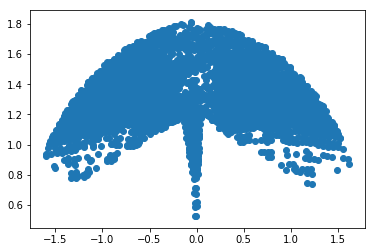

In [169]:
import pandas, numpy

#fpts = "timscanpoints/vg-off-quick.csv"
fpts = "timscanpoints/vg-off-slow.csv"
w = pandas.read_csv(fpts)
w.angle = ((w.angle+180)%360) - 180   # move to range [-180,180]
w.distance = w.distance/1000          # to metres

w["x"] = w.distance * numpy.sin(numpy.radians(w.angle))
w["y"] = w.distance * numpy.cos(numpy.radians(w.angle)) * numpy.cos(numpy.radians(w.angle_below_horizon))
w["z"] = -w.distance * numpy.cos(numpy.radians(w.angle)) * numpy.sin(numpy.radians(w.angle_below_horizon))
w = w[numpy.abs(w.angle)<55]
w = w[w.distance<2]
w = w[w.angle_below_horizon<45]
w.index = numpy.array(range(len(w)))

plt.scatter(w.x, w.y)


In [185]:
import ipyvolume as ipv
ipv.clear()
ipv.scatter(w.x, w.y, w.z, size=0.5)

px, py, d  = -0.5, 1.4, 0.1
b = w[(w.x - px)**2 + (w.y - py)**2 < d**2]
b.index = numpy.array(range(len(b)))
ipv.scatter(b.x, b.y, b.z, size=0.5, color="blue")

ipv.show()


In [227]:
qx, qy, qz, qu, qv, qw = [ ], [ ], [ ], [ ], [ ], [ ]
px, py, d, atten = -0.5, 1.4, 0.1, 5

pxy = [ ]
for px in numpy.linspace(-1, 1, 20):
    pxy.append((px, 1.4))
for px in numpy.linspace(0, 1.5, 17):
    pxy.append((px, 1.8-px/2))
    pxy.append((-px, 1.8-px/2))

for px, py in pxy:
    b = w[(w.x - px)**2 + (w.y - py)**2 < d**2]
    mx, my = b.x - px, b.y - py
    weights = 1/(1/atten + mx**2 + my**2)
    c = polyfitsurf(mx, my, b.z, 2, weights)
    qx.append(px);  qy.append(py);  qz.append(c[-1])
    n = polysurfnormal0(c)
    qu.append(-n[0]);  qv.append(-n[1]);  qw.append(-n[2])
    


In [229]:
ipv.clear()
ipv.scatter(w.x, w.y, w.z, size=0.5)
ipv.quiver(numpy.array(qx), numpy.array(qy), numpy.array(qz), 
           numpy.array(qu), numpy.array(qv), numpy.array(qw), 
           color="cyan", size=10)
ipv.show()


In [235]:
pxy = zip(*map(lambda X: X.flatten(), numpy.meshgrid(
          numpy.linspace(-1.5, 1.5, 60), numpy.linspace(1, 1.8, 30))))

qx, qy, qz, qu, qv, qw = [ ], [ ], [ ], [ ], [ ], [ ]
px, py, d, atten = -0.5, 1.4, 0.1, 8
deg = 2
pr = 0.1
for px, py in pxy:
    b = w[(w.x - px)**2 + (w.y - py)**2 < d**2]
    if len(b) > 20:
        mx, my = b.x - px, b.y - py
        weights = 1/(1/atten + mx**2 + my**2)
        c = polyfitsurf(mx, my, b.z, deg, weights)
        n = polysurfnormal0(c)
        qx.append(px-n[0]*pr);  qy.append(py-n[1]*pr);  qz.append(c[-1]-n[2]*pr)
        qu.append(-n[0]);  qv.append(-n[1]);  qw.append(-n[2])
    


In [234]:
ipv.clear()
#ipv.scatter(w.x, w.y, w.z, size=0.5)
ipv.quiver(numpy.array(qx), numpy.array(qy), numpy.array(qz), 
           numpy.array(qu), numpy.array(qv), numpy.array(qw), 
           color="cyan", size=10)
ipv.show()


In [236]:
ipv.clear()
#ipv.scatter(w.x, w.y, w.z, size=0.5)
ipv.quiver(numpy.array(qx), numpy.array(qy), numpy.array(qz), 
           numpy.array(qu), numpy.array(qv), numpy.array(qw), 
           color="cyan", size=10)
ipv.show()
